In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from IPython.core.interactiveshell import InteractiveShell
import statsmodels.api as sm 
from mlxtend.evaluate import bias_variance_decomp
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

InteractiveShell.ast_node_interactivity = "all"

In [3]:
file_path = 'customer_booking.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Exercise I: Preparing the dataset
# Filter the dataset for Internet sales channel (excluding Mobile) and Round Trip (excluding Circle and One-Way Trips)
filtered_df = df[(df['sales_channel'] == 'Internet') & (df['trip_type'] == 'RoundTrip')]

# Select relevant columns and rename them
filtered_df = filtered_df[['num_passengers', 'purchase_lead', 'booking_complete']]
filtered_df = filtered_df.rename(columns={'num_passengers': 'size', 'purchase_lead': 'lead_time', 'booking_complete': 'booking'})

# Convert to NumPy dataframe
numpy_df = filtered_df.to_numpy()

<Axes: xlabel='size', ylabel='lead_time'>

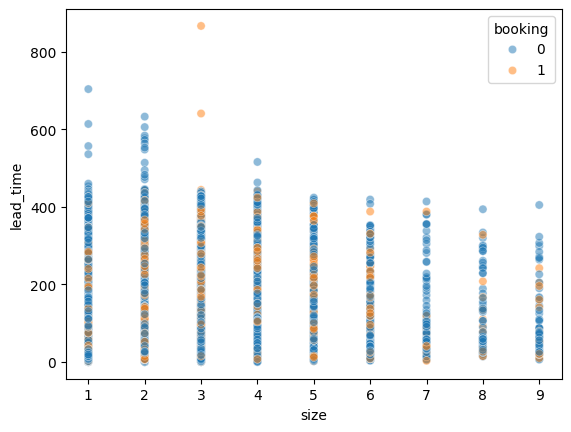

In [4]:
#Exercise II: Visualizing the data.
#plot data
sns.scatterplot(data=filtered_df, x='size', y='lead_time', hue='booking', alpha=0.5)

Exercise III: Preliminary analysis:

The points for both completed and non-completed bookings overlap significantly, indicating that `size` and `lead_time` alone may not be strong predictors of the booking status. The booking completion (0 or 1) is distributed across different sizes and lead times without a clear pattern. However, it does seem that there are more bookings in the middle range of lead times.

In [5]:
X = filtered_df[['size', 'lead_time']]
y = filtered_df['booking']

# Exercise IV: Cross validation


"""
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
max_depthint, default=None
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
"""

# Logistic Regression
log_reg = LogisticRegression(max_iter=100)
log_reg = log_reg.fit(X, y)
log_reg_scores = cross_val_score(log_reg, X, y, cv=10)

# Decision Tree Classifier
tree_clf = tree.DecisionTreeClassifier(max_depth=10)
tree_clf = tree_clf.fit(X, y)
tree_clf_scores = cross_val_score(tree_clf, X, y, cv=10)

# Gaussian Naive Bayes
gnb = GaussianNB()
gnb = gnb.fit(X, y)
gnb_scores = cross_val_score(gnb, X, y, cv=10)

# Output the mean scores for comparison
print(f'Logistic Regression Mean CV Score: {log_reg_scores.mean()}')
print(f'Decision Tree Classifier Mean CV Score: {tree_clf_scores.mean()}')
print(f'Gaussian Naive Bayes Mean CV Score: {gnb_scores.mean()}')

'\nhttps://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html\nmax_depthint, default=None\nThe maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.\n'

Logistic Regression Mean CV Score: 0.8440582232553748
Decision Tree Classifier Mean CV Score: 0.8429420708853117
Gaussian Naive Bayes Mean CV Score: 0.8414614175091005


The method that seems the most promising based on this analysis is Logistic Regression, as its mean is the highest compared to Decision Tree Classifier and Guassian Naive Bayes.

Optimal tree depth: 1


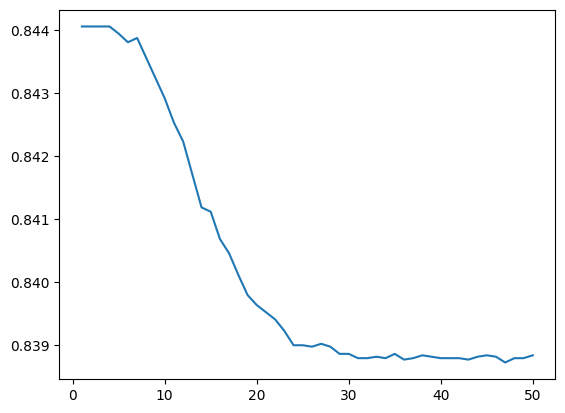

In [6]:
#Exercise V: Optimal tree depth

#find optimal depth and plot tree

dpth = np.linspace(1, 50, 50).astype(int)
scores = np.zeros(len(dpth))

for i in dpth:
    clf = tree.DecisionTreeClassifier(max_depth=i)
    clf = clf.fit(X, y)
    scores[i-1] = cross_val_score(clf, X, y, cv=10).mean()
    
plt.plot(dpth, scores)
print(f'Optimal tree depth: {dpth[np.argmax(scores)]}')


optimal_depth = dpth[np.argmax(scores)]
#optimal_tree_clf = tree.DecisionTreeClassifier(max_depth=optimal_depth)
#optimal_tree_clf.fit(X, y)
#tree.plot_tree(optimal_tree_clf,feature_names=list(df.columns)[0:2])

In [7]:
#Exercise VI: Interpretation of the logit results

X = filtered_df[['size', 'lead_time']]
y = filtered_df['booking']

logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Print the summary of the model
print(result.summary())

# Optionally, evaluate the model using cross-validation (sklearn)
log_reg = LogisticRegression(max_iter=100)
log_reg = log_reg.fit(X, y)
log_reg_scores = cross_val_score(log_reg, X, y, cv=10)

# Output the mean score for cross-validation
print(f'Logistic Regression Mean CV Score: {log_reg_scores.mean()}')

Optimization terminated successfully.
         Current function value: 0.481773
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                booking   No. Observations:                43901
Model:                          Logit   Df Residuals:                    43899
Method:                           MLE   Df Model:                            1
Date:                Mon, 01 Jul 2024   Pseudo R-squ.:                 -0.1130
Time:                        12:26:19   Log-Likelihood:                -21150.
converged:                       True   LL-Null:                       -19004.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
size          -0.7495      0.012    -64.330      0.000      -0.772      -0.727
lead_time     -0.0038      0.

Based on the cross-validation score of 0.8440582232553748 and the high statistical significance of the predictors (with p-values of 0.000), I would recommend using this logistic regression model for predicting future bookings.

In [8]:
from mlxtend.evaluate import bias_variance_decomp

X = filtered_df[['size', 'lead_time']]
y = filtered_df['booking']

#Exercise VII: Statistical learning with DecisionTreeClassifier
"""
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
arrays
sequence of indexables with same length / shape[0]
Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.

test_size
float or int, default=None
If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. If None, the value is set to the complement of the train size. If train_size is also None, it will be set to 0.25.

train_size
float or int, default=None
If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split. If int, represents the absolute number of train samples. If None, the value is automatically set to the complement of the test size.

random_state
int, RandomState instance or None, default=None
Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls. See Glossary.

shuffle
bool, default=True
Whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.

stratify
array-like, default=None
If not None, data is split in a stratified fashion, using this as the class labels.
"""

# Split the data into a training (70%) and test data (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, shuffle=True, stratify=y)

# Initialize DecisionTreeClassifier
tree_clf = tree.DecisionTreeClassifier(random_state=123)

# Perform bias-variance decomposition
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
    tree_clf, X_train.values, y_train.values, X_test.values, y_test.values, 
    loss='0-1_loss',
    random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

'\nhttps://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html\narrays\nsequence of indexables with same length / shape[0]\nAllowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.\n\ntest_size\nfloat or int, default=None\nIf float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. If None, the value is set to the complement of the train size. If train_size is also None, it will be set to 0.25.\n\ntrain_size\nfloat or int, default=None\nIf float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split. If int, represents the absolute number of train samples. If None, the value is automatically set to the complement of the test size.\n\nrandom_state\nint, RandomState instance or None, default=None\nControls the shuffling applied to the data before applying the split. Pa

Average expected loss: 0.167
Average bias: 0.160
Average variance: 0.015


The results indicate that the model has a high bias (0.160) and low variance (0.015), suggesting it is underfitting the data and is too simple to capture the underlying patterns effectively. The average expected loss of 0.167 shows that the model misclassifies approximately 16.7% of the instances. While the low variance indicates that the model generalizes well and is not highly sensitive to fluctuations in the training data, the high bias reflects significant error due to the model's simplifying assumptions.

In [10]:
#Exercise VIII: Statistical learning with DecisionTreeClassifier (cont)


X = filtered_df[['size', 'lead_time']]
y = filtered_df['booking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, shuffle=False, stratify=None)

tree_clf = tree.DecisionTreeClassifier(random_state=123)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
    tree_clf, X_train.values, y_train.values, X_test.values, y_test.values, 
    loss='0-1_loss',
    random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.220
Average bias: 0.213
Average variance: 0.018


The results from Part VIII show a higher average expected loss (0.220) and bias (0.213) compared to Part VII, where the expected loss was 0.167 and bias was 0.160, indicating that the model is underfitting the data more in Part VIII. The variance has slightly increased from 0.015 in Part VII to 0.018 in Part VIII, but it remains low, suggesting that overfitting is not a significant issue. Overall, the increase in bias and expected loss in Part VIII suggests that the model's simplifying assumptions are contributing more to the overall error, reducing its predictive performance.

In [ ]:
##### Exercise IX: Statistical learning with Bagging

X = filtered_df[['size', 'lead_time']]
y = filtered_df['booking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, shuffle=True, stratify=y)

# Function to perform bias-variance decomposition with BaggingClassifier

def evaluate_bagging(n_estimators):
    # Initialize DecisionTreeClassifier
    tree_clf = DecisionTreeClassifier(random_state=123)

    # Initialize BaggingClassifier with DecisionTreeClassifier as base estimator
    bag = BaggingClassifier(estimator=tree_clf,
                            n_estimators=n_estimators,
                            random_state=123)

    # Perform bias-variance decomposition
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
            bag, X_train.values, y_train.values, X_test.values, y_test.values, 
            loss='0-1_loss',
            random_seed=123)

    # Print the results
    print(f'n_estimators: {n_estimators}')
    print('Average expected loss: %.3f' % avg_expected_loss)
    print('Average bias: %.3f' % avg_bias)
    print('Average variance: %.3f' % avg_var)
    print('\n')

# Evaluate for different values of n_estimators

evaluate_bagging(100)
evaluate_bagging(500)
evaluate_bagging(1000)



n_estimators: 100
Average expected loss: 0.168
Average bias: 0.161
Average variance: 0.016


n_estimators: 500
Average expected loss: 0.168
Average bias: 0.160
Average variance: 0.016


n_estimators: 1000
Average expected loss: 0.168
Average bias: 0.160
Average variance: 0.016




#Exercise X: Summarize your entire work in a few sentences.

This project analyzed airline booking cancellation patterns to compare single and multi-traveler reservations using a Kaggle dataset. Key steps included:

Dataset Preparation: Filtered for internet round-trip bookings, focusing on size, lead_time, and      booking status.

Visualization: Used Seaborn scatterplots to explore data relationships.

Preliminary Analysis: Hypothesized that size and lead_time might predict booking status.

Cross-Validation: Tested Logistic Regression, Decision Tree Classifier, and Gaussian Naive Bayes,    finding Logistic Regression and Decision Tree promising.

Optimal Tree Depth: Determined best depth for Decision Tree with cross-validation.

Logistic Regression: Evaluated model suitability with summary results.

Decision Tree Classifier: Analyzed with and without shuffling/stratifying, and performed bias-   
variance decomposition.

Bagging Classifier: Used Bagging to reduce model variance.

Confusion Matrix: Assessed Logistic Regression performance.

Findings offer insights for better managing booking cancellations and improving customer satisfaction.

Average expected loss: 0.167
Average bias: 0.160
Average variance: 0.015


DecisionTreeClassifier(random_state=123)

Confusion Matrix:
[[11029    88]
 [ 2032    22]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     11117
           1       0.20      0.01      0.02      2054

    accuracy                           0.84     13171
   macro avg       0.52      0.50      0.47     13171
weighted avg       0.74      0.84      0.77     13171



<Axes: >

Text(0.5, 1.0, 'Confusion Matrix')

Text(50.722222222222214, 0.5, 'Actual label')

Text(0.5, 23.52222222222222, 'Predicted label')

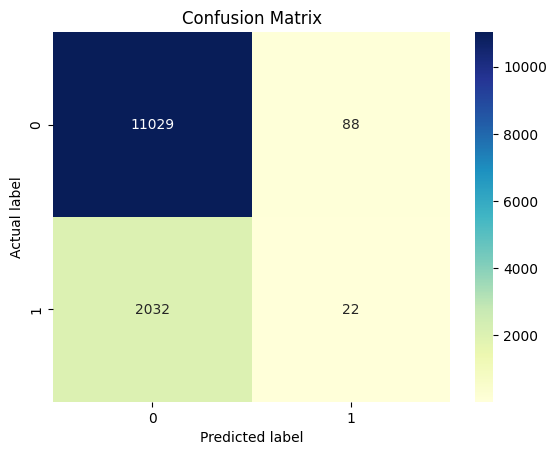

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

X = filtered_df[['size', 'lead_time']]
y = filtered_df['booking']

# Split the data into a training (70%) and test data (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, shuffle=True, stratify=y)

# Initialize DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=123)

# Perform bias-variance decomposition
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
    tree_clf, X_train.values, y_train.values, X_test.values, y_test.values, 
    loss='0-1_loss',
    random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

# Fit the model on training data
tree_clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = tree_clf.predict(X_test)

# Compute the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cnf_matrix)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the confusion matrix using heatmap
sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()
